In [34]:
%matplotlib inline
import codecs, os, sys, json, string
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from sklearn import preprocessing
# import sympy
# from sympy import symbols, integrate
from sympy import *

In [35]:
def join_path(d, file):
    return os.path.join(d, file)

In [36]:
data_path = "..\\data\\extracted\\"
bhot100 = pd.read_csv(join_path(data_path, 'hot-100.csv'))
bhot100['title'] = bhot100.apply(lambda row: row['title'].lower().strip(), axis=1)
bhot100['artist_name'] = bhot100.apply(lambda row: row['artist_name'].lower().strip(), axis=1)
grammy = pd.read_csv(join_path(data_path, 'grammy.csv'), 
                     dtype={'award_for': 'str',
                            'name': 'str'
                        })
grammy['award_for'] = grammy.apply(lambda row: str(row['award_for']).lower().strip(), axis=1)
grammy['name'] = grammy.apply(lambda row: str(row['name']).lower().strip(), axis=1)
grammy = grammy[grammy['award_type']=='Individual']
ama = pd.read_csv(join_path(data_path, 'ama.csv'), 
                    dtype={'award_for': 'str',
                            'name': 'str'
                    })
ama['award_for'] = ama.apply(lambda row: str(row['award_for']).lower().strip(), axis=1)
ama['name'] = ama.apply(lambda row: str(row['name']).lower().strip(), axis=1)

msd = pd.read_csv(join_path(data_path, 'MSDSet.csv'))
msd['artist_name'] = msd.apply(lambda row: str(row['artist_name']).lower().strip(), axis=1)
msd['title'] = msd.apply(lambda row: str(row['title']).lower().strip(), axis=1)


In [67]:
spotify = pd.read_csv(join_path(data_path, 'spotify2.csv'))
spotify['title'] = spotify.apply(lambda row: str(row['title']).lower().strip(), axis=1)
spotify['artist_name'] = spotify.apply(lambda row:str(row['artist_name']).lower().strip(), axis=1)

In [37]:
titles = bhot100.title
merge_song_bhot100 = bhot100[['title', 'artist_name', 'current_rank']].groupby(['title', 'artist_name']).sum()
count_onchart_bhot100 = bhot100[['title', 'artist_name', 'current_rank']].groupby(['title', 'artist_name'])\
                        .count().rename(columns={"current_rank": "onchart_count"})
bhot100_song_num = len(merge_song_bhot100)

# count_onchart_bhot100 = count_onchart_bhot100.sort_values('onchart_count', ascending=False)
# count_onchart_bhot100
avr_bhot100_ranks = merge_song_bhot100.current_rank / count_onchart_bhot100.onchart_count
avr_bhot100_ranks.sort_values()
# avr_bhot100_ranks['Radioactive']


title                                            artist_name                                
zeze                                             kodak black featuring travis scott & offset      4.666667
in my feelings                                   drake                                            5.722222
sicko mode                                       travis scott                                     6.307692
girls like you                                   maroon 5 featuring cardi b                       6.478261
get back                                         the beatles with billy preston                   6.833333
mrs. brown you've got a lovely daughter          herman's hermits                                 7.000000
i want to hold your hand                         the beatles                                      7.533333
hey jude                                         the beatles                                      7.842105
i like it                                        ca

In [38]:
overall_avr_bhot_rank = np.mean(avr_bhot100_ranks)
print (overall_avr_bhot_rank)
blamda = 1/overall_avr_bhot_rank
print (blamda)

61.82629783506455
0.016174347082332556


In [39]:
def rank_prob(rank):
    x = symbols('x')
    return integrate(blamda * exp(blamda*(x-100)), (x, rank-1, rank))
#     return blamda*np.exp(blamda*(rank-100))

In [40]:
rank_prob(1)/rank_prob(2)

0.983955755284751

In [41]:
rank_prob(1)/rank_prob(10)

0.864530128451833

In [42]:
rank_prob(1)/rank_prob(25)

0.678287303057853

In [43]:
rank_prob(1)/rank_prob(50)

0.452692131013324

In [44]:
rank_prob(1)/rank_prob(100)

0.201642215756864

In [45]:
rank_prob(1)/rank_prob(101)

0.198407018702331

In [46]:
rank_prob(1)

0.00323519705453182

In [49]:
rank_prob_table_bhot100 = [float(rank_prob(i)) for i in range(1, 101)]
rankprobsum = np.sum(rank_prob_table_bhot100)
rankprobsum

0.8015929812976694

In [50]:
out_chart_prob = 1-rankprobsum
rank_prob_table_bhot100.append(out_chart_prob)
rank_prob_table_bhot100

[0.0032351970545318187,
 0.003287949724523509,
 0.0033415625721626985,
 0.003396049623385494,
 0.003451425132833086,
 0.003507703587580846,
 0.0035648997109283265,
 0.003623028466251288,
 0.00368210506091593,
 0.003742144950257875,
 0.0038031638416251845,
 0.0038651776984877095,
 0.003928202744613446,
 0.003992255468312944,
 0.004057352626752664,
 0.004123511250339329,
 0.004190748647174669,
 0.004259082407584547,
 0.0043285304087195,
 0.004399110819232832,
 0.004470842104033257,
 0.004543743029115643,
 0.0046178326664707,
 0.004693130399074097,
 0.004769655925957794,
 0.004847429267363312,
 0.004926470769979485,
 0.005006801112265313,
 0.00508844130985997,
 0.0051714127210806815,
 0.005255737052510201,
 0.005341436364676155,
 0.005428533077821596,
 0.00551704997777136,
 0.005607010221892361,
 0.005698437345152629,
 0.005791355266277831,
 0.005885788294009209,
 0.005981761133462715,
 0.006079298892592733,
 0.006178427088760208,
 0.006279171655408811,
 0.006381558948849009,
 0.006485615

In [ ]:
# f_score_table_bhot100 = -np.log(rank_prob_table_bhot100)
# f_score_table_bhot100
# f_norm_score_table_bhot100 = preprocessing.MinMaxScaler()\
#         .fit_transform(np.array(f_score_table_bhot100).reshape(-1, 1))
# f_norm_score_table_bhot100 = f_norm_score_table_bhot100.reshape(-1).tolist()
# f_norm_score_table_bhot100

In [51]:
score_table_bhot100 = [1/i for i in rank_prob_table_bhot100]
score_table_bhot100

[309.10018250641457,
 304.14090353675357,
 299.26119245248435,
 294.4597726469934,
 289.73538799584355,
 285.086802528166,
 280.51280010331413,
 276.01218409268813,
 271.5837770667109,
 267.22642048675556,
 262.93897440207985,
 258.7203171515918,
 254.56934507040185,
 250.48497220108567,
 246.46613000959653,
 242.5117671056939,
 238.62084896792436,
 234.79235767291246,
 231.0252916291347,
 227.31866531482186,
 223.6715090201632,
 220.0828685936123,
 216.55180519225618,
 213.07739503621912,
 209.65872916696608,
 206.29491320951965,
 202.98506713847084,
 199.72832504775744,
 196.52383492412125,
 193.37075842421407,
 190.26827065528104,
 187.2155599593348,
 184.21182770084323,
 181.2562880577629,
 178.34816781598462,
 175.48670616702475,
 172.67115450900513,
 169.90077625079383,
 167.17484661931346,
 164.49265246991575,
 161.8534920998258,
 159.25667506455423,
 156.70152199727968,
 154.18736443110066,
 151.71354462416502,
 149.27941538759438,
 146.88433991616418,
 144.52769162170975,
 142

In [52]:
norm_score_table_bhot100 = preprocessing.MinMaxScaler((1, 100))\
        .fit_transform(np.array(score_table_bhot100).reshape(-1, 1))
norm_score_table_bhot100 = (norm_score_table_bhot100).reshape(-1).tolist()
norm_score_table_bhot100

[99.99999999999999,
 98.38529054703532,
 96.79648788767526,
 95.23317636698701,
 93.69494699890325,
 92.1813973592293,
 90.69213148036376,
 89.22675974770266,
 87.7848987977208,
 86.36617141766527,
 84.97020644687932,
 83.59663867969914,
 82.24510876990905,
 80.91526313673064,
 79.60675387232557,
 78.31923865076892,
 77.05238063850477,
 75.80584840620506,
 74.579315842088,
 73.37246206658087,
 72.1849713483833,
 71.01653302186605,
 69.86684140579288,
 68.73559572335593,
 67.62250002348085,
 66.52726310340628,
 65.44959843249835,
 64.38922407729197,
 63.3458626277301,
 62.31924112459073,
 61.30909098807889,
 60.31514794755507,
 59.33715197240775,
 58.37484720401522,
 57.42798188881836,
 56.496308312450225,
 55.579582734936416,
 54.677565326924515,
 53.79002010694495,
 52.916714879670145,
 52.05742117517317,
 51.21191418915273,
 50.37997272412523,
 49.56137913155115,
 48.755919254898316,
 47.96338237361516,
 47.183561148001296,
 46.416251564965535,
 45.66125288465183,
 44.91836758792438,

In [53]:
grammy_num = len(grammy)
grammy['cnt'] = grammy['year']
artist_grammy_count = grammy[['name', 'cnt']].groupby(['name']).count()
artist_grammy_count

,cnt
name,
'ikena,1
'round midnight,2
(everything i do) i do it for you (from robin hood - prince of thieves),1
(hey won't you play) another somebody done somebody wrong song,1
(i'm a) stand by my woman man,1
(i've had) the time of my life,1
(sittin' on) the dock of the bay,2
(there's) no gettin' over me,1
...again,1


In [54]:
# both grammy and billboard started from 1958
grammy_score = bhot100_song_num/grammy_num*100
grammy_score

912.5860373647985

In [55]:
#ama started from 1974
ama['cnt'] = ama['year']
ama_num = len(ama)
ama_score = bhot100_song_num/ama_num*100*(2018-1974)/(2018-1958)
ama_score

1982.3495145631068

In [57]:
def get_year_billboard_rank_score(rs):
    s = 0
    for r in rs:
        s += norm_score_table_bhot100[int(r-1)]
    s += (52 - len(rs))*norm_score_table_bhot100[100]
    return s

In [60]:
def get_scores(br, gr, ar, release_year):
    # order: from the year to now (which is 2018-1958)
    b_onchart_ranks = [[] for i in range(61)]
    for i in range(len(br)):
        on_chart_date_year = int(br.iloc[i]['chart_date'].split('-')[0])
        if on_chart_date_year >= 1958 and on_chart_date_year <= 2018:
            b_onchart_ranks[on_chart_date_year-1958].append(br.iloc[i]['current_rank'])
    
    grammy_wins = [0 for i in range(61)]
    for i in range(len(gr)):
        grammy_win_year = int(gr.iloc[i]['year'])
        grammy_win[grammy_win_year - 1958] = 1
    
    
    ama_wins = [0 for i in range(61)]
    for i in range(len(gr)):
        ama_win_year = int(ar.iloc[i]['year'])
        ama_win[ama_win_year - 1958] = 1
    
    final_scores = []
    for i in range(61):
        bill_year_score = get_year_billboard_rank_score(b_onchart_ranks[i])
        grammy_year_score = grammy_wins[i]*grammy_score
        ama_year_score = ama_wins[i]*ama_score
        final_scores.append(bill_year_score+grammy_year_score+ama_year_score)
    final_scores.reverse()
    return final_scores
    

In [82]:
def generate_feature():
    # from 01/04/1958 - 11/10/2018 22228 days which are 3175 weeks, 61 years
    mbhotd = merge_song_bhot100.reset_index()
    titles = mbhotd['title'].tolist()
    artists = mbhotd['artist_name'].tolist()
    feature_d = {'title':[],
                'artist_name':[],
                'spotify_popularity_2018':[]}
    for i in range(0, 61):
        feature_d['y_'+str(i)] = []
    
    for title, name in zip(titles, artists):
        bill_records = bhot100[(bhot100['title']==title) & (bhot100['artist_name']==name)]
        grammy_records = grammy[(grammy['award_for']==title) & (grammy['name']==name)]
        ama_records = ama[(ama['award_for']==title) & (ama['name']==name)]
        spotify_records = spotify[(spotify['title']==title) & (spotify['artist_name']==name)]
        
        if len(spotify_records) == 0:
            print (title, name)
            continue
        
#         print (spotify_records)
#         print (np.argmax(spotify_records['spotify_score'].tolist()))
        sr_real = spotify_records.iloc[np.argmax(spotify_records['spotify_score'].tolist())]
        popularity_2018 = sr_real['spotify_score']
        datestr = str(sr_real['release_date'])

        if len(datestr) <= 4:
#             release_date = pd.to_datetime(datestr+'-1-1',format='%Y-%m-%d')
            release_date = datestr + '-1-1'
        elif len(datestr) == 6 or len(datestr) == 7:
#             release_date = pd.to_datetime(datestr+'-1',format='%Y-%m-%d')
            release_date = datestr + '-1'
        else:
            release_date = datestr
#             release_date = pd.to_datetime(datestr, format='%Y-%m-%d')
        release_year = int(release_date.split('-')[0])
        scores = get_scores(bill_records, grammy_records, ama_records, release_year)
        
        # put in feature dictionary
        feature_d['title'].append(title)
        feature_d['artist_name'].append(name)
        feature_d['spotify_popularity_2018'].append(popularity_2018)
        for i in range(0, 61):
            feature_d['y_'+str(i)].append(scores[i])
    feature_df = pd.DataFrame.from_dict(feature_d)
    feature_df.to_csv(join_path(data_path, 'features.csv'))
        

In [83]:
import time
st = time.time()
generate_feature()
time.time()-st

"b" girls young and restless
"cherry cherry" from hot august night neil diamond
"having a party" medley the ovations (featuring louis williams)
"joy" pt. i isaac hayes
"roots" medley quincy jones
"yep!" duane eddy his twangy guitar and the rebels
'98 thug paradise tragedy, capone, infinite
'til it's time to say goodbye jonathan cain
(a ship will come) ein schiff wird kommen lale anderson
(baby) turn on to me the impressions
(call me) when the spirit moves you touch
(come on) shout alex brown
(do the) push and pull part i rufus thomas
(doin' the) lovers leap webb pierce
(how bout a little hand for) the boys in the band the boys in the band
(how can i write on paper) what i feel in my heart jim reeves
(how i spent my summer vacation) or a day at the beach with pedro & man - p cheech & chong
(i don't want to love you but) you got me anyway sutherland brothers and quiver
(i know) i'm losing you uptown
(i will be your) shadow in the street allan clarke
(i'd know you) anywhere ashford & simp

baby, you're driving me crazy joey dee
baciare baciare (kissing kissing) dorothy collins
back at the chicken shack, part 1 jimmy smith
back door man derek
back in the u.s.s.r. chubby checker
back of my hand (i've got your number) the jags
back seat (of my jeep) ll cool j
back to paradise (from "revenge of the nerds ii") thirty eight special
back up off me! doctor dre & ed lover
back where you belong thirty eight special
bad bad boys midi maxi & efti
bad boys (theme from "cops") inner circle
bad, bad billy snuff
baggage claim miranda lambert
ballad of a girl and boy graduates
ballad of the alamo bud & travis
bam jay-z featuring damian "jr. gong" marely
bangla-desh/deep blue george harrison
banjo boy art mooney and his orchestra
banjo boy dorothy collins
baretta's theme ("keep your eye on the sparrow") rhythm heritage
basketball jones featuring tyrone shoelaces cheech & chong
batdance (from "batman") prince
battle hymn of lt. calley c company featuring terry nelson
be anything (but be mi

cradle of love (from "ford fairlane") billy idol
crank it up (funk town) pt. 1 peter brown
crazy eyes for you bobby hamilton
crazy love (from "jason's lyric") brian mcknight
crooklyn (from "crooklyn") the crooklyn dodgers
cross my broken heart (from "beverly hills cop ii") the jets
cry like a baby kim carnes
cry me a river janice harper
cryin' in the streets (part 1) george perkins & the silver stars
crying in the chapel adam wade
cuando calienta el sol (when the sun is hot) steve allen and his orchestra with the copacabana trio
cuddly toy (feel for me) roachford
curious mind (um, um, um, um, um, um) johnny rivers
cuz it's you, girl james walsh gypsy band
d.o.a. (death of auto-tune) jay-z
da doo ron ron (when he walked me home) ian matthews
da'butt (from the "school daze" soundtrack) e.u.
dammit isn't god's last name frankie laine
damn it all gene cotton
dance across the floor jimmy "bo" horne
dance little lady dance danny white
dance master pt. 1 willie henderson
dance wit' me - part 

fever/my crew rita coolidge
ffun confunkshun
fibbin' patti page
fiesta dave "baby" cortez
find 'em, fool 'em & forget 'em dobie gray
finder's keepers chairman of the board
finders keepers, losers weepers nella dodds
fire & rain r.b. greaves
fire sign cory
first anniversary cathy carr
first name initial annette with the afterbeats
first of the year (equinox) sonny "skrillex" john moore
first...be a woman lenore o'malley
five hundred miles heaven bound with tony scotti
flamingo l'amore the gaylords
flash's theme aka flash queen
flashes tiggi clay
fly by night andy williams
fly like an eagle (from "space jam") seal
fly me to the moon - bossa nova joe harnell and his orchestra
flying circle frank slay and his orchestra
follow me lyme & cybelle
follow you down/til i hear it from you gin blossoms
fool for a pretty face (hurt by love) humble pie
fool for your love jimmy hall
foolish games/you were meant for me jewel
fools hall of fame pat boone
fools like me lorenzo lamas
foot stompin music h

hey little lucy! (don'tcha put no lipstick on) conway twitty
hey little one j. frank wilson and the cavaliers
hey lonely one baby washington
hey lover debbie dovale
hey shirley (this is squirrely) shirley & squirrely
hey there little firefly part i firefly
hey! love/over and over the delfonics
hi diddle diddle inez foxx
hi heel sneakers - pt. 1 ramsey lewis trio
hi hi hazel gary and the hornets
hide & go seek, part i bunker hill
high hopes frank sinatra "and a bunch of kids"
high on your love debbie jacobs
high school u.s.a. tommy facenda
high time we went/black-eyed blues joe cocker
highfly john miles
hijack herbie mann
hippy hippy shake (from "cocktail") the georgia satellites
history repeats itself buddy starcher
history repeats itself cab calloway
hit it again 3oh!3
hobo flats - part i jimmy smith
hold on i'm coming chuck jackson & maxine brown
holy man diane kolby
home bound ted nugent
home of the brave bonnie & the treasures
hook and sling-part i eddie bo
hoop in yo face (from "s

i'd rather be alone iv xample
i'll always love my mama (part i) the intruders
i'll be holding on al downing
i'll be home for christmas (live) josh groban
i'll be there joyce "fenderella" irby
i'll come running livingston taylor
i'll drink to you duke jupiter
i'll know her when i see her cooper brothers band
i'll make you music beverly bremers
i'll never fall in love again johnnie ray
i'll remember (from "with honors") madonna
i'll remember (in the still of the night) santo & johnny
i'll remember tonight pat boone
i'll take care of your cares frankie laine
i'll take you home the corsairs featuring jay "bird" uzzell
i'll take you there (from "threesome") general public
i'm a fool to care oscar black
i'm a fool to care ray charles
i'm a greedy man - part i james brown
i'm back t.i.
i'm dreamin' (from "new jack city") christopher williams
i'm every woman (from "the bodyguard") whitney houston
i'm girl scoutin' the intruders
i'm gonna be a wheel some day fats domino
i'm gonna change him cat

lawdy miss clawdy gary stites
lay lady lay ferrante & teicher
lazy eyes t.m.g.
le bel age (the best years) pat benatar
leave it all to me (icarly theme song) miranda cosgrove featuring drake bell
leaving l.a. deliverance
leflaur leflah eshkushka heltah skeltah and o.g.c. as the fab 5
left right out of your heart (hi lee hi lo hi lup up up) patti page
let it go (from "set it off") ray j
let it shine/he ain't heavy...he's my brother olivia newton-john
let me be the one peaches & herb
let me party with you (part 1) (party, party, party) bunny sigler
let me sleep alone cugini
let the music heal your soul bravo all stars
let the river run (theme from "working girl") carly simon
let's call it a day girl bobby vee
let's go again (where we went last night) hank ballard and the midnighters
let's go through the motions (from "who's the man?") jodeci
let's hang on! the 4 seasons featuring the "sound of frankie valli"
let's lay together (from "don't be a menace...") the isley brothers
let's live t

mom and dad's waltz patti page
moments jennell hawkins
money can't buy you love (from "mo' money") ralph tresvant
money won't change you (part 1) james brown and the famous flames
mongoose elephant's memory
monkey-shine bill black's combo
monster mash bobby "boris" pickett and the crypt-kickers
monsters' holiday bobby "boris" pickett and the crypt-kickers
montage from how sweet it is (i know that you know) the love generation
montego bay amazulu
moody blue/she thinks i still care elvis presley
moon talk perry como
moon walk part 1 joe simon
moonflight vik venus alias: your main moon man
moonlight and roses (bring mem'ries of you) vic dana
moonlight on water kevin raleigh
more bounce to the ounce part i zapp
more than just the two of us sneaker
more than the eye can see al martino
morning much better ten wheel drive with genya ravan
mother popcorn (you got to have a mother for me) part 1 james brown
moulty the barbarians
move (if you 'w'anna) mims
move me, o wondrous music the ray charl

please, mr. president paula webb
plenty good lovin' connie francis
pocketful of rainbows deane hawley
pony with the golden mane every mothers' son
pop goes the movies part i meco
pop that booty marques houston featuring jermaine "jd" dupri
pops, we love you (a tribute to father) diana ross, marvin gaye, smokey robinson & stevie wonder
portrait of a fool conway twitty
postcard from jamaica the sopwith "camel"
potato peeler bobby gregg and his friends
pow wow cory daye
powerful stuff (from "cocktail") the fabulous thunderbirds
prayer in c lillywood & robin schulz
pretty good at drinkin' beer billy currington
pretty mess vanity
prisoner (captured by your eyes) l.a. jets
prisoner of your love player
project chick cash money millionaires
promise me a rose (a slight detail) anita bryant
promise me, love andy williams
puddin n' tain (ask me again, i'll tell you the same) the alley cats
puff of smoke roy head
puffin' on down the track hugh masekela
pump it (nice an' hard) icy blu
puppet man/re

sittin' up in my room (from "waiting to exhale") brandy
sitting in limbo don brown
six boys and seven girls anita bryant
six packs a day billy lemmons
sixty minute man/mother-in-law clarence carter
skat strut mc skat kat & the stray mob
skate now lou courtney
skokiaan (south african song) bill haley and his comets
sky pilot (part one) eric burdon & the animals
slim jenkin's place booker t. & the mg's
slip-in mules (no high heel sneakers) sugar pie desanto
slipin' and slidin' jim and monica
smells like nirvana "weird al" yankovic
smile jay-z featuring gloria carter
smiling islands robbie patton
smoky places the corsairs featuring jay "bird" uzzell
snow blind friend steppenwolf
so complicated carolyn dawn johnson
so far away/smackwater jack carole king
so far so good (from "about last night") sheena easton
so hard livin' without you airwaves
so in love with you u.n.v.
so many ways (from "high school high") the braxtons
so you are a star the hudson brothers
sockin' 1-2-3-4 john roberts
so

the answer to a maiden's prayer june valli
the astronaut (parts 1 & 2) jose jimenez
the ballad of irving frank gallop
the basie twist count basie & his orch.
the battle of new orleans vaughn monroe
the beatles' movie medley the beatles
the best man in the world ann wilson
the big bang rockmafia
the big time spender (parts i & ii) cornbread & biscuits
the biggest parakeets in town jud strunk
the birth of the beat sandy nelson
the blind man in the bleachers kenny starr
the bonnie and clyde theme yo-yo
the boys' night out patti page
the breakdown (part i) rufus thomas
the breaks (part 1) kurtis blow
the brigade of broken hearts paul evans
the brightest smile in town ray charles and his orchestra
the charanga merv griffin
the cheer leader paul petersen
the children's marching song (nick nack paddy whack) mitch miller and his "sing along with mitch" chorus
the children's marching song (nick nack taddy whack) cyril stapleton and his orchestra
the chipmunk song (christmas don't be late) (2007

too good to turn back now rick bowles
too hotty quavo, takeoff & offset
too many cooks (spoil the soup) 100 proof aged in soul
too many fish in the sea & three little fishes mitch ryder and the detroit wheels
too pooped to pop ("casey") chuck berry
top of the world (make my reservation) canyon
topsy i cozy cole
tossin' and turnin' bunny sigler
touch me baby (reaching out for your love) tamiko jones
touch me tease me (from "the nutty professor") case featuring foxxy brown
touch me when we're dancing bama
touch myself (from "fled") t-boz
toy soldier the 4 seasons featuring the "sound of frankie valli"
tracy's theme spencer ross
travelin' band/who'll stop the rain creedence clearwater revival
travelin' soldier dixie chicks
travlin' man stevie wonder
tremor christ/spin the black circle pearl jam
trouble in my home/i found my dad joe simon
truck stop jerry smith and his pianos
truly, truly, true brenda lee
trust in me patti page
try (try to fall in love) cooker
try it on exile
tubthumping c

wish that i could talk to you the sylvers
wish you were here, buddy pat boone
wishes (from "kazaam") nathan morris
wishin' on a rainbow phill wilson
wishing it was you connie francis
wishing on the same star keedy
witch doctor (2007) alvin and the chipmunks featuring chris classic
witchi tai to everything is everything
with my eyes wide open i'm dreaming enoch light & the light brigade
with the wind and the rain in your hair pat boone
without love (there is nothing) ray charles
without the one you love (life's not worth while) four tops
without you/never forget you mariah carey
without your love (mr. jordan) charlie ross
wkrp in cincinnati steve carlisle
wombling summer party the wombles
women's love rights laura lee
won'cha come home, bill bailey della reese
woo-hah!! got you all in check/everything remains raw busta rhymes
wood beez (pray like aretha franklin) scritti politti
word crimes "weird al" yankovic
words (are impossible) donny gerrard
work it (reinvention) nelly
working my w

2647.375054836273

In [84]:
feature_df = pd.read_csv(join_path(data_path, 'features.csv'))
FEATURES = ['y_'+str(i) for i in range(0, 61)]
print (len(feature_df))

25326


In [86]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(feature_df[FEATURES], feature_df['spotify_popularity_2018'])
lr_coefs = lr.coef_
print ('Coefficients of Linear Regression: \n', lr_coefs)

Coefficients of Linear Regression: 
 [ 0.03956997  0.02442002  0.02137775  0.02154763  0.02063737  0.01872502
  0.01902984  0.01800889  0.01118261  0.01826658  0.0158763   0.01750166
  0.01805834  0.01686226  0.01572006  0.01628724  0.01563094  0.01244777
  0.01350211  0.01716678  0.01062532  0.00926389  0.01198285  0.01199193
  0.01258619  0.01466292  0.01150296  0.00876019  0.01079349  0.01257791
  0.01475569  0.01478439  0.0144467   0.01442818  0.01590204  0.01391318
  0.01060682  0.01220148  0.0099384   0.01365614  0.0135411   0.01107083
  0.01199657  0.00866109  0.00903188  0.00882748  0.01165807  0.00865886
  0.00472077  0.00392174  0.00442137  0.00414493  0.00303307  0.0022319
  0.00104998 -0.00371944 -0.00613672 -0.00689941 -0.00535008 -0.00453734
 -0.00670548]


<BarContainer object of 61 artists>

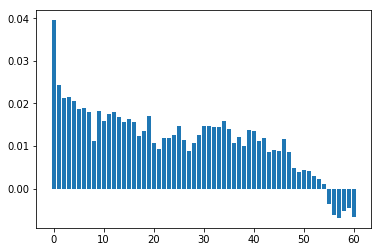

In [89]:
plt.bar(range(len(lr_coefs)), lr_coefs)

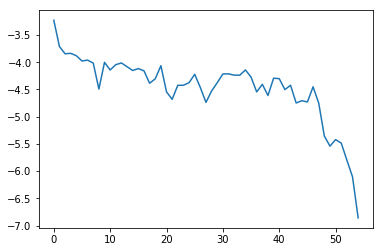

In [91]:
plt.plot(range(len(lr_coefs)), np.log(lr_coefs))

In [ ]:
np